In [0]:
import os
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
# This is white wine
wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',delimiter=";")
# This is red wine
datared = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',delimiter=";")

In [4]:
wine.shape

(4898, 12)

In [5]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [7]:
wine.isnull().sum()
# no missing values

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
wine.dtypes
# all features are quantitive

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [24]:
data, target = train_test_split(wine, test_size=898,random_state=42) 
# later on split "data" into train & validate. Put "target" in a vault.
print("%s %s"%(data.shape,target.shape))

(4000, 12) (898, 12)


In [0]:
X=data[data.columns[0:11]]  # features
Y=pd.DataFrame(data[data.columns[11]])    # labels (quality)
Y.loc[Y['quality'] == 3,'quality'] = 'low'
Y.loc[Y['quality'] == 4, "quality"] = 'low'
Y.loc[Y['quality'] == 5, "quality"] = 'medium'
Y.loc[Y['quality'] == 6,'quality'] = 'medium'
Y.loc[Y['quality'] == 7, "quality"] = 'medium'
Y.loc[Y['quality'] == 8, "quality"] = 'high'
Y.loc[Y['quality'] == 9,'quality'] = 'high'

target_X=target[target.columns[0:11]]  # features
target_Y=pd.DataFrame(target[target.columns[11]]) # labels (quality)
target_Y.loc[target_Y['quality'] == 3,'quality'] = 'low'
target_Y.loc[target_Y['quality'] == 4, "quality"] = 'low'
target_Y.loc[target_Y['quality'] == 5, "quality"] = 'medium'
target_Y.loc[target_Y['quality'] == 6,'quality'] = 'medium'
target_Y.loc[target_Y['quality'] == 7, "quality"] = 'medium'
target_Y.loc[target_Y['quality'] == 8, "quality"] = 'high'
target_Y.loc[target_Y['quality'] == 9,'quality'] = 'high'

👆 Not sure how to re-label

In [26]:
print(Y.quality.value_counts())
print(target_Y.quality.value_counts())

medium    3700
low        154
high       146
Name: quality, dtype: int64
medium    835
high       34
low        29
Name: quality, dtype: int64


In [28]:
# X is imbalanced. Thus use stratifiedKFold to split data
# get the indices
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)
for train, test in skf.split(X, Y):
    print("%s %s" % (len(train),len(test)))

2999 1001
2999 1001
3001 999
3001 999


In [29]:
# cross validation
from sklearn import svm
from sklearn.model_selection import cross_val_score
svm_clf = svm.SVC(kernel='linear')
accuracy = cross_val_score(svm_clf, X, Y.values.ravel(), scoring='accuracy', cv = skf).mean() * 100
print("Accuracy of SVM model1 is: " , accuracy)

Accuracy of SVM model1 is:  92.5000925000925


In [0]:
...

In [31]:
# suppose model1 is the best after tweaking all those parameters
# fit the model with 4000 data points from "data"
# predict data from "target". Then use some metrics to evaluate accuracy. 
svm_clf.fit(X,Y.values.ravel())
target_predicted = svm_clf.predict(target_X)
accuracy_score(target_Y,target_predicted)

0.9298440979955457

# Worklist
## EDA: 
correlation, each feature count plot, label plot, outliers? label transformation? 1-9 to low medium high
split:4898 -> 
## Feature
keep

## Modeling

** SVM **

** Random Forest **

** Naive Bayes **

** DT **

** KNN=1 **

## Evaluation

Confusion Matrix


### EDA

In [0]:
# data['quality'] 

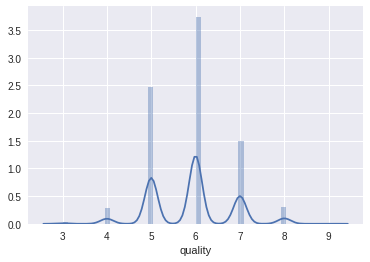

In [62]:
sns.distplot(data['quality'])